# Desharnais

In [1]:
dataset = "desharnais_pre"

time: 714 µs


## Rohe Daten
Baue Datenbankverbindung auf und zeige 3 Beispieldaten aus dem vorbereiteten Datensatz "Desharnais".

In [2]:
from libs.data.Db import Db
import pandas as pd

db = Db().getDb()
desh = db[dataset]

data = pd.DataFrame(
    list(desh.find({}, { 'id': 0, '_id': 0 }))
)

list(desh.find().limit(3))

[{'_id': ObjectId('5cb0a9db27e2fe003483a1f2'),
  'Effort': 5152.0,
  'Project': 1.0,
  'id': 1.0,
  'Entities': -0.8012587574370996,
  'Envergure': 0.6256714445467177,
  'Length': 0.10401747754604196,
  'ManagerExp': 0.8945595320809094,
  'PointsAdjust': 0.10591863402422147,
  'PointsNonAdjust': 0.03858613239441162,
  'TeamExp': -0.9839927200551898,
  'Transactions': 0.5204504967277443,
  'Is_BasicCobol': 0.8660254037844386,
  'Is_AdvancedCobol': -0.6526300069150406,
  'Is_4GL': -0.3863337046431279},
 {'_id': ObjectId('5cb0a9db27e2fe003483a1f3'),
  'Effort': 805.0,
  'Project': 3.0,
  'id': 3.0,
  'Entities': -0.7077431464895336,
  'Envergure': -0.9037476421230364,
  'Length': -1.5275159202594701,
  'ManagerExp': 0.8945595320809094,
  'PointsAdjust': -1.0769329723005763,
  'PointsNonAdjust': -1.0935367297724816,
  'TeamExp': 1.2890304632722986,
  'Transactions': -0.9472091657261302,
  'Is_BasicCobol': 0.8660254037844386,
  'Is_AdvancedCobol': -0.6526300069150406,
  'Is_4GL': -0.3863337

time: 506 ms


### Data

In [3]:
import pandas as pd

X_data = pd.DataFrame(
    list(desh.find({}, { 'Project': 0, 'YearEnd': 0, 'Effort': 0, 'id': 0, '_id': 0 }))
)
y_data = pd.DataFrame(
    list(desh.find({}, { 'Effort': 1, '_id': 0 }))
)
header = list(X_data.columns.values)

time: 9.65 ms


Funktion zum Berechnen der Baumtiefe

In [4]:
def dectree_max_depth(tree):
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

time: 5.23 ms


# Multirun

In [5]:
from sklearn.model_selection import train_test_split
from libs.evaluation.Metrics import Metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from libs.tree.ModelTree import ModelTree
from sklearn.ensemble import RandomForestRegressor
from libs.forest.RandomForestModelTree import RandomForestModelTree
from sklearn.metrics import make_scorer
from datetime import datetime
import pandas as pd
import numpy as np
import os
import time

def my_scorer(y_true, y_pred):
    return Metrics().pred(y_true, y_pred)

X = X_data.values
y = np.ravel(y_data.values.astype('float')) # scikit needs to know what kind of problem to solve

n_runs = 30
m_dt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_mt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfdt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfmt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
for i in range(n_runs):
    print("{}/{}".format(i+1, n_runs))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    searchSpace_trees = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None] # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        # do not test splitter here, see: https://stackoverflow.com/a/46759065
    }
    
    searchSpace_forests = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None], # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        "bootstrap": [True, False],
        #"oob_score": [True],
        "n_estimators": [20],
        "n_jobs": [-1]
    }
    
    #--------------------------
    print("DT")
    start_time = time.clock()
    
    rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_dt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_dt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        dt = DecisionTreeRegressor(
            criterion = rs_dt.best_params_["criterion"],
            max_depth = rs_dt.best_params_["max_depth"],
            min_samples_split = rs_dt.best_params_["min_samples_split"],
            min_samples_leaf = rs_dt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_dt.best_params_["max_leaf_nodes"],
            max_features = rs_dt.best_params_["max_features"]
        )
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(dt.tree_)))
        print(Metrics().mer(y_test, y_pred))

    m_dt['mmre'].append(np.mean(mmres))
    m_dt['mdmre'].append(np.mean(mdmres))
    m_dt['pred'].append(np.mean(preds))
    m_dt['mmer'].append(np.mean(mmers))
    m_dt['mdmer'].append(np.mean(mdmers))
    m_dt['mae'].append(np.mean(maes))
    m_dt['mbre'].append(np.mean(mbres))
    m_dt['mibre'].append(np.mean(mibres))
    m_dt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("MT")
    start_time = time.clock()
    
    rs_mt = RandomizedSearchCV(ModelTree(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_mt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_mt.best_params_))
    
    mmres_mt = []
    mdmres_mt = []
    preds_mt = []
    mmers_mt = []
    mdmers_mt = []
    maes_mt = []
    mbres_mt = []
    mibres_mt = []
    sas_mt = []
    for i in range(1):
        mt = ModelTree(
            criterion = rs_mt.best_params_["criterion"],
            max_depth = rs_mt.best_params_["max_depth"],
            min_samples_split = rs_mt.best_params_["min_samples_split"],
            min_samples_leaf = rs_mt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_mt.best_params_["max_leaf_nodes"],
            max_features = rs_mt.best_params_["max_features"]
        )
        mt.fit(X_train, y_train)
        y_pred = mt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres_mt.append(metrics['mmre'])
        mdmres_mt.append(metrics['mdmre'])
        preds_mt.append(metrics['pred'])
        mmers_mt.append(metrics['mmer'])
        mdmers_mt.append(metrics['mdmer'])
        maes_mt.append(metrics['mae'])
        mbres_mt.append(metrics['mbre'])
        mibres_mt.append(metrics['mibre'])
        sas_mt.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(mt.tree_)))
        print(Metrics().mer(y_test, y_pred))

    m_mt['mmre'].append(np.mean(mmres_mt))
    m_mt['mdmre'].append(np.mean(mdmres_mt))
    m_mt['pred'].append(np.mean(preds_mt))
    m_mt['mmer'].append(np.mean(mmers_mt))
    m_mt['mdmer'].append(np.mean(mdmers_mt))
    m_mt['mae'].append(np.mean(maes_mt))
    m_mt['mbre'].append(np.mean(mbres_mt))
    m_mt['mibre'].append(np.mean(mibres_mt))
    m_mt['sa'].append(np.mean(sas_mt))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFDT")
    start_time = time.clock()
    
    rs_rfdt = RandomizedSearchCV(RandomForestRegressor(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfdt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfdt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfdt = RandomForestRegressor(
            criterion = rs_rfdt.best_params_["criterion"],
            max_depth = rs_rfdt.best_params_["max_depth"],
            min_samples_split = rs_rfdt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfdt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfdt.best_params_["max_leaf_nodes"],
            max_features = rs_rfdt.best_params_["max_features"],
            bootstrap = rs_rfdt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfdt.fit(X_train, y_train)
        y_pred = rfdt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print(Metrics().mer(y_test, y_pred))

    m_rfdt['mmre'].append(np.mean(mmres))
    m_rfdt['mdmre'].append(np.mean(mdmres))
    m_rfdt['pred'].append(np.mean(preds))
    m_rfdt['mmer'].append(np.mean(mmers))
    m_rfdt['mdmer'].append(np.mean(mdmers))
    m_rfdt['mae'].append(np.mean(maes))
    m_rfdt['mbre'].append(np.mean(mbres))
    m_rfdt['mibre'].append(np.mean(mibres))
    m_rfdt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFMT")
    start_time = time.clock()
    
    rs_rfmt = RandomizedSearchCV(RandomForestModelTree(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfmt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfmt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfmt = RandomForestModelTree(
            criterion = rs_rfmt.best_params_["criterion"],
            max_depth = rs_rfmt.best_params_["max_depth"],
            min_samples_split = rs_rfmt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfmt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfmt.best_params_["max_leaf_nodes"],
            max_features = rs_rfmt.best_params_["max_features"],
            bootstrap = rs_rfmt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfmt.fit(X_train, y_train)
        y_pred = rfmt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print(Metrics().mer(y_test, y_pred))

    m_rfmt['mmre'].append(np.mean(mmres))
    m_rfmt['mdmre'].append(np.mean(mdmres))
    m_rfmt['pred'].append(np.mean(preds))
    m_rfmt['mmer'].append(np.mean(mmers))
    m_rfmt['mdmer'].append(np.mean(mdmers))
    m_rfmt['mae'].append(np.mean(maes))
    m_rfmt['mbre'].append(np.mean(mbres))
    m_rfmt['mibre'].append(np.mean(mibres))
    m_rfmt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))

print("DT:")
print("MMRE: {}\n{}".format(np.mean(m_dt['mmre']), m_dt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_dt['mdmre']), m_dt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_dt['pred']), m_dt['pred']))
print("MMER: {}\n{}".format(np.mean(m_dt['mmer']), m_dt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_dt['mdmer']), m_dt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_dt['mae']), m_dt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_dt['mbre']), m_dt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_dt['mibre']), m_dt['mibre']))
print("SA: {}\n{}".format(np.mean(m_dt['sa']), m_dt['sa']))
print("------------------------------------------------")
print("MT:")
print("MMRE: {}\n{}".format(np.mean(m_mt['mmre']), m_mt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_mt['mdmre']), m_mt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_mt['pred']), m_mt['pred']))
print("MMER: {}\n{}".format(np.mean(m_mt['mmer']), m_mt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_mt['mdmer']), m_mt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_mt['mae']), m_mt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_mt['mbre']), m_mt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_mt['mibre']), m_mt['mibre']))
print("SA: {}\n{}".format(np.mean(m_mt['sa']), m_mt['sa']))
print("------------------------------------------------")
print("RFDT:")
print("MMRE: {}\n{}".format(np.mean(m_rfdt['mmre']), m_rfdt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfdt['mdmre']), m_rfdt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfdt['pred']), m_rfdt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfdt['mmer']), m_rfdt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfdt['mdmer']), m_rfdt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfdt['mae']), m_rfdt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfdt['mbre']), m_rfdt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfdt['mibre']), m_rfdt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfdt['sa']), m_rfdt['sa']))
print("------------------------------------------------")
print("RFMT:")
print("MMRE: {}\n{}".format(np.mean(m_rfmt['mmre']), m_rfmt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfmt['mdmre']), m_rfmt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfmt['pred']), m_rfmt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfmt['mmer']), m_rfmt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfmt['mdmer']), m_rfmt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfmt['mae']), m_rfmt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfmt['mbre']), m_rfmt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfmt['mibre']), m_rfmt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfmt['sa']), m_rfmt['sa']))
print("------------------------------------------------")

1/30
DT
best params: {'min_samples_split': 0.05, 'min_samples_leaf': 0.4, 'max_leaf_nodes': 5, 'max_features': 11, 'max_depth': 18, 'criterion': 'mae'}
desharnais_pre_1555143187668.csv
Tree-depth: 2
[0.74831619992910314, 0.46608695652173915, 0.062608695652173918, 0.23652173913043478, 3.5459057071960296, 1.248695652173913, 0.45987577639751553, 0.43478260869565216, 1.0992555831265509, 0.17369727047146402, 0.019130434782608695, 0.78956521739130436, 0.11652173913043479, 0.048695652173913043, 1.6278260869565218, 0.42679900744416871]
time: 6.667744000000001 (HT: 6.639359000000001)
MT
best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.4, 'max_leaf_nodes': 2, 'max_features': 2, 'max_depth': 11, 'criterion': 'mse'}
desharnais_pre_1555143199982.csv
Tree-depth: 2
[0.95456068225377178, 0.62115879252880857, 0.67426552909098569, 3.167242304915121, 1.552216227289452, 2.7465094889683539, 0.39011249050301633, 0.30573432421558899, 0.72187709473739903, 0.47536317073174034, 0.57603615715321121,

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.05, 'min_samples_leaf': 0.3, 'max_leaf_nodes': 5, 'max_features': 10, 'max_depth': 18, 'criterion': 'mae', 'bootstrap': True}
desharnais_pre_1555147390215.csv
[0.075430730898001883, 2.2270299380368348, 0.34807475999255866, 0.19891871176524609, 0.2162730344099979, 0.80248115846316348, 3.2396030739912658, 0.024136751198605377, 0.67352257597217113, 0.16409139415556886, 0.62668883711127488, 3.8848377523755087, 0.65909463208341579, 0.28000589338805409, 1.1437449640473907, 0.41041722573697259]
time: 41.80675299999996 (HT: 39.98674299999999)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 15, 'max_features': 4, 'max_depth': 18, 'criterion': 'mse', 'bootstrap': False}
desharnais_pre_1555148071235.csv
[0.17303738318789333, 3.1282708979377389, 2.4117670914600988, 1.7380669632071217, 0.085150591775956491, 0.95225527754813921, 2.285267895673504, 0.3612527

best params: {'min_samples_split': 0.15, 'min_samples_leaf': 0.3, 'max_leaf_nodes': 5, 'max_features': 2, 'max_depth': 13, 'criterion': 'mae'}
desharnais_pre_1555151702341.csv
Tree-depth: 3
[0.28535980148883372, 0.44090909090909092, 0.027272727272727271, 0.14143920595533499, 0.034739454094292806, 0.1712121212121212, 1.4044665012406947, 0.44168734491315137, 0.80645161290322576, 4.1166253101736974, 0.11166253101736973, 0.72575757575757571, 0.69696969696969702, 0.089330024813895778, 0.41935483870967744, 0.33498759305210918]
time: 7.682621999999924 (HT: 7.6501049999999395)
MT
best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.3, 'max_leaf_nodes': 15, 'max_features': 5, 'max_depth': 7, 'criterion': 'mse'}
desharnais_pre_1555151715559.csv
Tree-depth: 2
[0.55856803202628869, 0.73094795149621083, 0.458516736678591, 0.51392641826582508, 0.034958465274737331, 0.26003420796784277, 0.90196755329526057, 1.660835573988529, 0.85444770422369765, 1.4259906990430093, 0.42828572106289814, 0.87

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.3, 'min_samples_leaf': 0.5, 'max_leaf_nodes': 10, 'max_features': 5, 'max_depth': 8, 'criterion': 'mae', 'bootstrap': False}
desharnais_pre_1555155867520.csv
[0.23464912280701755, 0.85526315789473684, 0.19956140350877194, 0.44736842105263158, 1.006578947368421, 1.4605263157894737, 0.23026315789473684, 0.08771929824561403, 0.55921052631578949, 0.31892230576441105, 3.3421052631578947, 0.49780701754385964, 0.22587719298245615, 0.61403508771929827, 0.40789473684210525, 0.19078947368421054]
time: 40.96018100000015 (HT: 39.39262500000018)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.1, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 15, 'max_features': 8, 'max_depth': 14, 'criterion': 'mse', 'bootstrap': True}
desharnais_pre_1555156522985.csv
[4.208034937481842, 0.40104201365113357, 0.2943759317965392, 33.751086964728628, 1.5181766248667432, 0.36742398712042101, 2.4817865788950417, 0.44419866086

best params: {'min_samples_split': 0.05, 'min_samples_leaf': 0.5, 'max_leaf_nodes': 10, 'max_features': 2, 'max_depth': 10, 'criterion': 'mae'}
desharnais_pre_1555160123022.csv
Tree-depth: 1
[0.89130434782608692, 0.27470355731225299, 0.64229249011857703, 0.10869565217391304, 0.63043478260869568, 1.2173913043478262, 0.59486166007905139, 0.54347826086956519, 0.11462450592885376, 0.76086956521739135, 0.59090909090909094, 0.28063241106719367, 0.11462450592885376, 3.2272727272727271, 0.081027667984189727, 0.77272727272727271]
time: 7.721907999999985 (HT: 7.6989280000000235)
MT
best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 15, 'max_features': 2, 'max_depth': 1, 'criterion': 'mae'}
desharnais_pre_1555160136647.csv
Tree-depth: 3
[0.72068199976247616, 2.1364725686923367, 1.0634168433550601, 1.411262606660808, 0.28445141883340569, 0.49284946813764674, 3.0216439697470907, 1.7840206550047235, 3.2615456449839861, 0.86787518666749985, 0.14729550406130815, 0.74547

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.15, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 2, 'max_features': 9, 'max_depth': 5, 'criterion': 'mae', 'bootstrap': False}
desharnais_pre_1555164323521.csv
[0.42224640728190166, 0.55339007288409015, 0.76581444950027822, 4.6556059616998642, 0.775683743987857, 0.69079479722829795, 2.2861520795928696, 4.0343119714592417, 0.78443387649748164, 4.3862676614935996, 0.28799341349738339, 0.42898676335869496, 0.38287519816563081, 0.033579149337639509, 0.66817898043933766, 0.24102405969047694]
time: 47.791443999999956 (HT: 45.32629199999997)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 5, 'max_features': 8, 'max_depth': 4, 'criterion': 'mse', 'bootstrap': True}
desharnais_pre_1555165121100.csv
[0.027745552680029067, 0.012625383610314142, 0.7858539324281546, 3.3426472132159408, 0.78896172697064026, 0.59745006777703347, 1.5318776513260919, 3.324125

best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 20, 'max_features': 9, 'max_depth': 18, 'criterion': 'mae'}
desharnais_pre_1555169008446.csv
Tree-depth: 4
[0.34042553191489361, 0.20458265139116202, 0.50107342206955774, 2.463917525773196, 0.63331902103907256, 0.29755259768140835, 5.0736377025036816, 3.7805596465390279, 0.31958762886597936, 0.45429740791268758, 0.72520908004778972, 0.10474631751227496, 0.83633387888707034, 0.1718494271685761, 0.8960927436668098, 0.84456848432803777]
time: 10.014529000000039 (HT: 9.981082000000242)
MT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 2, 'max_features': 10, 'max_depth': 13, 'criterion': 'mse'}
desharnais_pre_1555169023887.csv
Tree-depth: 2
[0.46276665627850272, 0.20234967702946929, 0.062779179468507404, 1.3415740048053719, 0.50835069912764885, 0.46205409341485904, 3.8838837433329627, 8.8202719499749787, 0.46460328036933241, 1.1046199292715611, 0.64210297674671268, 0.2594

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.15, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 10, 'max_features': 7, 'max_depth': 1, 'criterion': 'mae', 'bootstrap': False}
desharnais_pre_1555173415429.csv
[1.0849660099509741, 0.61521031911796342, 0.098272421920533065, 0.4928008649600859, 1.5547189175160558, 0.7468898279077455, 0.18802966431502463, 0.99098174698057984, 0.30564426486934748, 0.56885936348785304, 0.13812695365134872, 0.53462497602148473, 2.230833790312698, 2.9332343403141619, 0.28712917569928537, 6.0587070587070588]
time: 47.42950400000018 (HT: 45.13590400000021)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_leaf_nodes': None, 'max_features': 5, 'max_depth': 10, 'criterion': 'mae', 'bootstrap': True}
desharnais_pre_1555174156063.csv
[0.40994967516909836, 33.560950927955638, 1.7542196913562937, 0.99920488577288513, 2.4934797165602123, 0.11261113752055571, 0.088635089602742273, 0.897519

best params: {'min_samples_split': 0.3, 'min_samples_leaf': 0.3, 'max_leaf_nodes': 20, 'max_features': 5, 'max_depth': 6, 'criterion': 'mae'}
desharnais_pre_1555177937289.csv
Tree-depth: 3
[0.49169978957213001, 0.29981718464351004, 0.034739454094292806, 0.19639934533551553, 0.42679900744416871, 0.50822669104204754, 0.41935483870967744, 0.74954296160877509, 0.71464019851116622, 0.29280397022332505, 0.47166361974405852, 0.19106699751861042, 0.076923076923076927, 0.54661791590493602, 0.76923076923076927, 3.6513911620294599]
time: 7.876596999999947 (HT: 7.850018000000091)
MT
best params: {'min_samples_split': 0.05, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 20, 'max_features': 2, 'max_depth': 1, 'criterion': 'mse'}
desharnais_pre_1555177951781.csv
Tree-depth: 3
[0.31699920492067324, 0.42274045087477141, 0.33370662417123897, 0.40114124143111657, 2.9429236960729233, 0.19910331122260269, 0.42785781970256442, 0.0096809377424403511, 0.73877532308447902, 0.9471079293352358, 0.34811665180646867,

## Vergleich

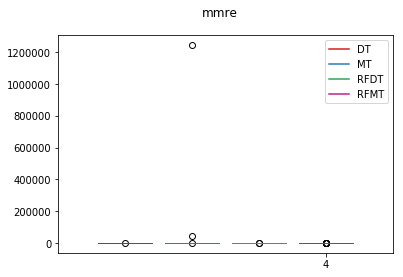

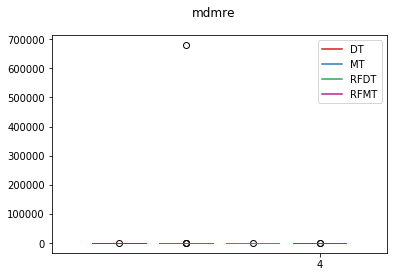

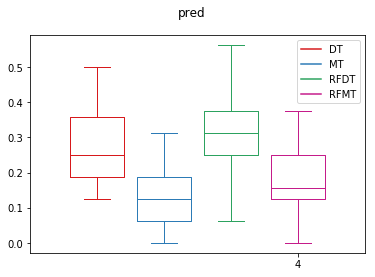

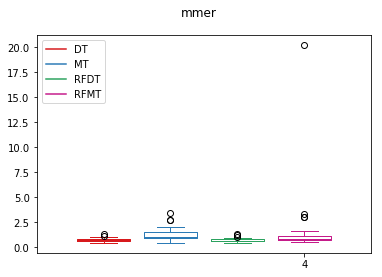

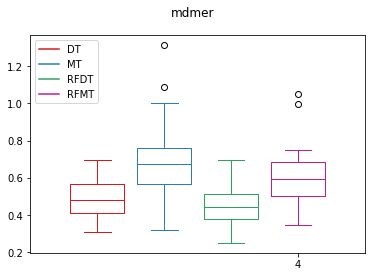

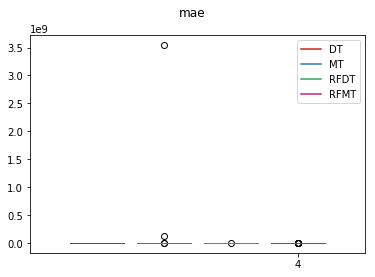

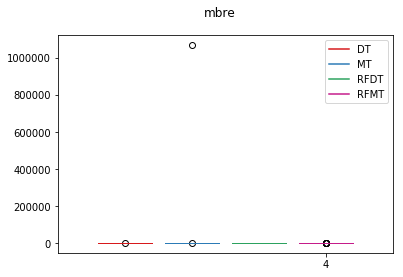

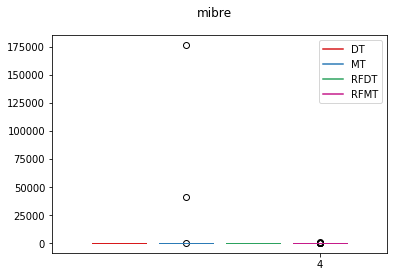

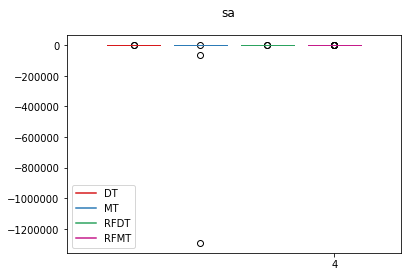

time: 4.82 s


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']

for item in ticks:
    fig, ax = plt.subplots()
    fig.suptitle("{}".format(item))
    bpll = ax.boxplot(m_dt[item], positions=[1], widths=0.8)
    bplr = ax.boxplot(m_mt[item], positions=[2], widths=0.8)
    bprl = ax.boxplot(m_rfdt[item], positions=[3], widths=0.8)
    bprr = ax.boxplot(m_rfmt[item], positions=[4], widths=0.8)
    set_box_color(bpll, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bplr, '#2C7BB6')
    set_box_color(bprl, '#2CA25F')
    set_box_color(bprr, '#C51B8A')
    ax.plot([], c='#D7191C', label='DT')
    ax.plot([], c='#2C7BB6', label='MT')
    ax.plot([], c='#2CA25F', label='RFDT')
    ax.plot([], c='#C51B8A', label='RFMT')
    ax.legend()
    plt.xlim(0, 5)

plt.show()

In [7]:
methods = ['dt', 'mt', 'rfdt', 'rfmt']
greater_is_better = [False, False, True, False, False, False, False, False, True]
ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']
for j, t in enumerate(ticks):
    values = []
    values.append(np.mean(m_dt[t]))
    values.append(np.mean(m_mt[t]))
    values.append(np.mean(m_rfdt[t]))
    values.append(np.mean(m_rfmt[t]))
    values_s = sorted(values, reverse = greater_is_better[j])
    rank = {}
    for i, method in enumerate(methods):
        c = values.index(values_s[i])
        rank[methods[c]] = i
        
    print("\t{}".format(t.upper()), end='', flush=True)
    for i, method in enumerate(methods):
        print(" & \cellcolor{{gr0{}}} {:.4f}".format(rank[method]+1, values[i]), end='', flush=True)
        
    print(" \\\\")

	MMRE & \cellcolor{gr02} 0.9628 & \cellcolor{gr04} 42849.8248 & \cellcolor{gr01} 0.9056 & \cellcolor{gr03} 59.5038 \\
	MDMRE & \cellcolor{gr02} 0.5203 & \cellcolor{gr04} 22647.3904 & \cellcolor{gr01} 0.4852 & \cellcolor{gr03} 0.7938 \\
	PRED & \cellcolor{gr02} 0.2708 & \cellcolor{gr04} 0.1250 & \cellcolor{gr01} 0.3063 & \cellcolor{gr03} 0.1812 \\
	MMER & \cellcolor{gr02} 0.7423 & \cellcolor{gr03} 1.2866 & \cellcolor{gr01} 0.7046 & \cellcolor{gr04} 1.7350 \\
	MDMER & \cellcolor{gr02} 0.4861 & \cellcolor{gr04} 0.6913 & \cellcolor{gr01} 0.4541 & \cellcolor{gr03} 0.5994 \\
	MAE & \cellcolor{gr02} 2705.1841 & \cellcolor{gr04} 122256692.5072 & \cellcolor{gr01} 2547.3727 & \cellcolor{gr03} 105219.2803 \\
	MBRE & \cellcolor{gr02} 1.2846 & \cellcolor{gr04} 35600.9516 & \cellcolor{gr01} 1.2068 & \cellcolor{gr03} 25.7866 \\
	MIBRE & \cellcolor{gr02} 0.4205 & \cellcolor{gr04} 7250.1598 & \cellcolor{gr01} 0.4034 & \cellcolor{gr03} 35.4522 \\
	SA & \cellcolor{gr02} 0.2037 & \cellcolor{gr04} -45168.8